# Next Venue Community Detection via Network Analysis in Seattle, WA

Some interesting related links:

https://pub.towardsai.net/social-network-analysis-of-game-of-thrones-in-networkx-ff21ef65dc11

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4028409/

https://towardsdatascience.com/python-interactive-network-visualization-using-networkx-plotly-and-dash-e44749161ed7

https://www.geeksforgeeks.org/directed-graphs-multigraphs-and-visualization-in-networkx/

https://pyvis.readthedocs.io/en/latest/




Ego Graph in networkx


## Imports List

In [2]:
import pandas as pd
import numpy as np
import requests
import folium
import itertools

import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from networkx.algorithms import community
import matplotlib

## Obtain the data for the venues network
### First get a list of venues in Seattle, WA to initialize our network: 
We will "seed" our network with ten venues returned from the Foursquare "explore" endpoint, within a 3200 meter radius of the center of Seattle, WA

In [3]:
CLIENT_ID = '' # Fill in ID 
CLIENT_SECRET = '' # Fill in Secret
VERSION = '20180605' # Foursquare API version

# Get request for foursquare: 

LIMIT = 10 # number of venues returned by Foursquare API
# latitude and longitude of Seattle, WA 
seattle_lat = '47.608013'
seattle_long = '-122.335167'
radius = 3200 # 2 mile radius = 3200 m

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    seattle_lat,
    seattle_long,
    radius,
    LIMIT)
results = requests.get(url).json()
seed_venues = results['response']['groups'][0]['items']

### Get Next Venues: 
From that initial list of venues we can get the venues people typically visit next using the "NextVenues" endpoint. Once we have that, we can use the "next venues" as the list of venues to query next, and then their "next venues" as the list to query after that, so on and so forth until we reach a sizeable network to draw conclusions from. 

In [9]:
def get_next_venues(parent_venue_id, parent_venue_name, parent_venue_category, parent_lat, parent_long, df_child_parents, df_venues_data): 
    """
    This function obtains the next venues data from the parent venue, and updates the dataframes. 
    :param parent_venue_id: (str) unique ID of the parent venue obtained from Foursquare, used in the NextVenues query
    :param parent_venue_name: (str) english name of the parent venue, used to update the venue data dataframe
    :param parent_venue_category: (str) primary category of the parent venue, used to update the venue data dataframe
    :param parent_lat: (float) latitude of parent venue
    :param parent_long: (float) longitude of parent venue
    :param df_child_parents: (pd.DataFrame) dataframe which contains the parent venue to next venues (children) data, as IDs.
                             contains columns ['venue_id', 'next_venue_0', 'next_venue_1', 'next_venue_2', 'next_venue_3', 'next_venue_4']
    :param df_venues_data: (pd.DataFrame) dataframe which contains the data associated with each venue, 
                            contains columns ['id', 'name', 'category', 'latitude', 'longitude']
    
    :return df_child_parents: (pd.DataFrame) df_child_parents dataframe from input, updated with a new row containing the parent_venue_id and the 
                               next venues id's obtained from the NextVenues endpoint.
    :return df_venues_data: (pd.DataFrame) df_venues_data dataframe from input, updated with any new venues from this query.
    """

    # if the parent venue data isn't already in the df_venues_data, update
    if parent_venue_id not in df_venues_data['id'].values: 
        df_venues_data = df_venues_data.append({'id': parent_venue_id, 
                                                'name': parent_venue_name,
                                                'category': parent_venue_category,
                                                'latitude': parent_lat, 
                                                'longitude': parent_long}, ignore_index=True)
    
    # send request for next venues using the parent venue id
    url_next = 'https://api.foursquare.com/v2/venues/{}/nextvenues?&client_id={}&client_secret={}&v={}'.format(
        parent_venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    response = requests.get(url_next).json()    
    items = response['response']['nextVenues']['items']

    # from the next venues, update the venues dataframe 
    for item in items: 
        venue_id = item['id']
        if (venue_id not in df_venues_data['id'].values) and (isinstance(venue_id,str)): # to prevent nans
            venue_name = item['name']
            venue_lat = item['location']['lat']
            venue_long = item['location']['lng']
            venue_category = [category['name'] for category in item['categories'] if category['primary']==True][0]
            df_venues_data = df_venues_data.append({'id': venue_id,
                                                    'name': venue_name, 
                                                    'category': venue_category, 
                                                    'latitude': venue_lat,
                                                    'longitude': venue_long}, ignore_index=True)
    
    # update the df_child_parents dataframe
    next_venues_ids = {'next_venue_{}'.format(ind): item['id'] for ind, item in enumerate(items) if isinstance(item['id'], str)}
    df_child_parents = df_child_parents.append({**{'venue_id': parent_venue_id}, **next_venues_ids}, ignore_index = True)
    
    return df_child_parents, df_venues_data

def obtain_network_data(seed_venues, n_loops = 3):
    """
    Wrapper function to return data for our network. 
    :param seed_venues: ()
    :param n_loops: (int) number of loops to build off of the seed venues. e.g. if n_loops = 1, then the function will return the 
    seed venues and the venues that are 'Next Venues' for those seed venues. If n_loops = 2, then the next venues of the next venues 
    of the seed venues will be included in the output, etc.
    """

    df_venues_data = pd.DataFrame(columns = ['id', 'name', 'category', 'latitude', 'longitude'])
    df_child_parents = pd.DataFrame(columns = ['venue_id', 'next_venue_0', 'next_venue_1', 'next_venue_2', 'next_venue_3', 'next_venue_4'])
    # seed data 
    for venue in seed_venues: 
        parent_venue = venue['venue']
        parent_venue_name = parent_venue['name']
        parent_venue_id = parent_venue['id']
        parent_venue_lat = parent_venue['location']['lat']
        parent_venue_long = parent_venue['location']['lng']
        parent_venue_category = [category['name'] for category in parent_venue['categories'] if category['primary']==True][0]
        df_child_parents, df_venues_data = get_next_venues(parent_venue_id,
                                                           parent_venue_name,
                                                           parent_venue_category, 
                                                           parent_venue_lat, 
                                                           parent_venue_long, 
                                                           df_child_parents, df_venues_data)

    df_venues_data.to_csv('../data/seattle_venues_data_initial.csv')
    df_child_parents.to_csv('../data/seattle_child_to_parents_venue_data_initial.csv')

    # for n layers out from seed data: 
    i = 0 
    while i < n_loops: 
        print("on loop: %s" %str(i+1))
        next_ven_cols = ['next_venue_0', 'next_venue_1', 'next_venue_2', 'next_venue_3', 'next_venue_4']
        for next_ven_col in next_ven_cols: 
            for next_ven_id in df_child_parents[next_ven_col]: 
                # some columns will be None in the event there aren't 5 next venues
                if (next_ven_id not in df_child_parents['venue_id'].values) and (isinstance(next_ven_id, str)): 
                    next_ven_name = df_venues_data.loc[df_venues_data['id'] == next_ven_id]['name'].values[0]
                    next_ven_category = df_venues_data.loc[df_venues_data['id'] == next_ven_id]['category'].values[0]
                    next_ven_lat = df_venues_data.loc[df_venues_data['id'] == next_ven_id]['latitude'].values[0]
                    next_ven_long = df_venues_data.loc[df_venues_data['id'] == next_ven_id]['longitude'].values[0]
                    try: 
                        df_child_parents, df_venues_data = get_next_venues(next_ven_id, 
                                                                           next_ven_name, 
                                                                           next_ven_category,
                                                                           next_ven_lat, 
                                                                           next_ven_long, 
                                                                           df_child_parents, df_venues_data)
                    except:
                        print("exception occurred with parent venue id: %s, parent venue name: %s" %(next_ven_id, next_ven_name))
                        continue
        i += 1
    # Save the final data: 
    df_venues_data.to_csv('../data/seattle_venues_data_{}_loops.csv'.format(n_loops))
    df_child_parents.to_csv('../data/seattle_child_to_parents_venue_data_{}_loops.csv'.format(n_loops))
    return df_venues_data, df_child_parents


In [10]:
# Run our function and generate the data we will use: 
df_venues_data, df_child_parents = obtain_network_data(seed_venues, n_loops = 4)

on loop: 1
on loop: 2
on loop: 3
on loop: 4


In [11]:
print('number of parent venues: %s' %len(df_child_parents))
df_child_parents.head()

number of parent venues: 246


venue_id              next_venue_0  \
0  41f98080f964a5203b1f1fe3  42f54f00f964a520cb261fe3   
1  42a63500f964a5200a251fe3  427ea800f964a520b1211fe3   
2  4b0c7f0bf964a5204f3e23e3  427ea800f964a520b1211fe3   
3  4a468425f964a52000a91fe3  41f98080f964a5203b1f1fe3   
4  4aa42487f964a520834520e3  427ea800f964a520b1211fe3   

               next_venue_1              next_venue_2  \
0  40b68100f964a5206e001fe3  47a4ec98f964a520834d1fe3   
1  473dec17f964a520664c1fe3  4c51cb5494790f4784aba7a1   
2  557eee70498e7a2c0297a62d  4c51cb5494790f4784aba7a1   
3  427ea800f964a520b1211fe3  4d41a7c7bd53f04db8994f15   
4  42a63500f964a5200a251fe3  40b13b00f964a520e1f61ee3   

               next_venue_3              next_venue_4  
0  427ea800f964a520b1211fe3  50a12449e4b005ec01be7505  
1  40b13b00f964a520e1f61ee3  4aa42487f964a520834520e3  
2  42a63500f964a5200a251fe3  40b13b00f964a520e1f61ee3  
3  449ae181f964a5209f341fe3  43655e80f964a52064291fe3  
4  4a9c40a2f964a520953620e3  4a735223f964a52020dc1fe3

In [12]:
print(len(df_venues_data))
df_venues_data.head()

305


id                    name          category  \
0  41f98080f964a5203b1f1fe3           Benaroya Hall      Concert Hall   
1  42f54f00f964a520cb261fe3             Wild Ginger  Asian Restaurant   
2  40b68100f964a5206e001fe3             Triple Door       Music Venue   
3  47a4ec98f964a520834d1fe3  Purple Café & Wine Bar          Wine Bar   
4  427ea800f964a520b1211fe3       Pike Place Market            Market   

    latitude   longitude  
0  47.607957 -122.336456  
1  47.608891 -122.337344  
2  47.608775 -122.337390  
3  47.608086 -122.334955  
4  47.609427 -122.341468

How many unique categories do we have in our venues? 

In [13]:
len(df_venues_data['category'].unique())

112

### Let's create a network overlaying a map to visualize how people move between venues: 

In [14]:
# Helper functions for plotting: 

def lat_long(venue_id, df_venues_data): 
    """Returns a tuple of lat, long coordinates given venue id"""
    lat = df_venues_data.loc[df_venues_data['id'] == venue_id]['latitude'].values[0]
    lng = df_venues_data.loc[df_venues_data['id'] == venue_id]['longitude'].values[0]
    return tuple([lat, lng])

def make_label(parent_id, child_id, df_venues_data): 
    """Returns string to use for label of id pair"""
    parent_name = df_venues_data.loc[df_venues_data['id'] == parent_id]['name'].values[0]
    child_name = df_venues_data.loc[df_venues_data['id'] == child_id]['name'].values[0]
    return "From: %s, To: %s" %(parent_name, child_name)


In [15]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[seattle_lat, seattle_long], zoom_start=12)

# add markers to map
for lat, lng, venue_name in zip(df_venues_data['latitude'], df_venues_data['longitude'], df_venues_data['name']):
    label = folium.Popup(venue_name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  

# add lines to map showing the connections from parent to child venues:
for next_venue_column in ['next_venue_0', 'next_venue_1', 'next_venue_2', 'next_venue_3', 'next_venue_4']:
    for parent_venue_id, next_venue_id in zip(df_child_parents['venue_id'], df_child_parents[next_venue_column]): 
        if isinstance(next_venue_id, str):
            parent_coords = lat_long(parent_venue_id, df_venues_data)
            next_venue_coords = lat_long(next_venue_id, df_venues_data)
            label = make_label(parent_venue_id, next_venue_id, df_venues_data)
            folium.PolyLine(
                [parent_coords, next_venue_coords],
                color = 'red', 
                popup = label
            ).add_to(map_seattle)
    
map_seattle

From this map we can already start to see some interesting things, for instance the bridges between geographical clusters of this network, e.g. the cluster in Fremont is linked to the cluster in Ballard via the "From: Hiram M. Chittenden Locks, To: Gas Works Park" edge. 

Another idea to explore is to examine the average physical distance of next venues, this would give us an idea of how far people are likely to hop from one location to another. This distance could potentially be dependent on the node's categories, e.g. you would expect hops from "Bars" to "Pizza Places" to be much shorter than hops from "Grocery Stores" to "Gas Stations". 

We could take this a bit further via Link Prediction (https://arxiv.org/pdf/1602.03636.pdf), where we aim to predict wheter a link between two nodes that are not yet linked will occur. Using the other properties of venues and connections in our network (latitude, longitude, category, edge weight, etc), can we predict links that will occur? This could lead to insights into which venues have a strong likelihood to be "next venues" or "previous venues". If you're a business owner, and a link between your store and a pizza place up the road is predicted, that could indicate a good opportunity to draw customers from that "previous venue", and you may consider advertising at or near that venue. 


https://medium.com/analytics-vidhya/a-gentle-introduction-to-networkx-with-python-21c29419d28a
1. for a subset of nodes, remove links 
2. predict new links in network and see if removed links are in that set of predicted links 

## Venues Network

We need to convert df_child_parents to a df with columns "parent_venue", "child_venue", "edge_weight" where edge weight will be dependent on ranking of next venue,one of 1.0, 0.8, 0.6, 0.4, or 0.2


In [16]:
df_venues_network = pd.DataFrame(columns = ['parent_venue', 'child_venue', 'edge_weight'])
i =0 
col_to_weight_dict = {'next_venue_0':1.0,'next_venue_1': 0.8, 'next_venue_2': 0.6, 'next_venue_3': 0.4, 'next_venue_4':0.2}
for next_venue_column, next_venue_weight in col_to_weight_dict.items(): 
    for parent_venue_id, child_venue_id in zip(df_child_parents['venue_id'], df_child_parents[next_venue_column]): 
        if isinstance(child_venue_id, str): 
            df_venues_network = df_venues_network.append({'parent_venue': df_venues_data.loc[df_venues_data['id'] == parent_venue_id]['name'].values[0], 
                                    'child_venue': df_venues_data.loc[df_venues_data['id'] == child_venue_id]['name'].values[0], 
                                    'edge_weight': next_venue_weight}, ignore_index = True)

# clean strings of any $ characters (cause errors in network)
df_venues_network['parent_venue'] = [ven.replace("$", "") for ven in df_venues_network['parent_venue']]
df_venues_network['child_venue'] = [ven.replace("$", "") for ven in df_venues_network['child_venue']]

### Plot network with matplotlib: 

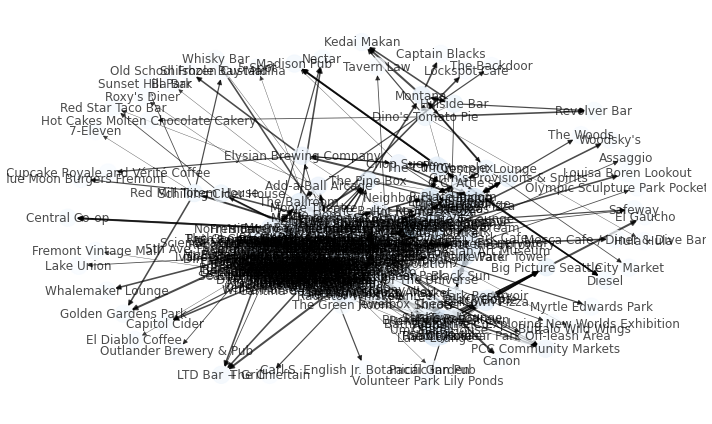

In [18]:
G = nx.DiGraph()
G.add_nodes_from(list(set(list(df_venues_network['parent_venue'].values)+ list(df_venues_network['child_venue'].values))))
edges = [tuple(r) for r in df_venues_network[['parent_venue', 'child_venue', 'edge_weight']].to_numpy()]
G.add_weighted_edges_from(edges)

# fixing the size of the figure 
plt.figure(figsize =(10, 6)) 
  
node_color = [G.degree(v) for v in G] 
# node colour is a list of degrees of nodes 

edge_width = [2*G[u][v]['weight'] for u, v in G.edges()]   
nx.draw_networkx(G,  
                 node_color = node_color, alpha = 0.7, 
                 with_labels = True, width = edge_width,  
                 cmap = plt.cm.Blues) 
  
plt.axis('off') 
plt.tight_layout()

### We can do better than that - let's try pyvis: 

In [19]:

venue_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed = True, 
                    notebook = True, heading = "Next Venue Check-In's Network of Seattle, WA")

# set the physics layout of the network
venue_net.barnes_hut(spring_length = 1,overlap = 0)

sources = df_venues_network['parent_venue']
targets = df_venues_network['child_venue']
weights = df_venues_network['edge_weight']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    # get value of node from the networkx implementation: 
    venue_net.add_node(src, src, title=src)
    venue_net.add_node(dst, dst, title=dst)
    venue_net.add_edge(src, dst, value=w)

# this returns the list of next venue categories this each category is connected to
neighbor_map = venue_net.get_adj_list()

# add neighbor data to node hover data
for node in venue_net.nodes:
    node["title"] += "<br> Parent Venues: <br>" + "<br>".join([k for k,v in neighbor_map.items() if node["id"] in v]) + "<br>  <br>" + \
                      "Next Venues:<br>" + "<br>".join(neighbor_map[node["id"]])
    # lets make the node size proportional to how many venues "feed" into the node, a measure of the hub-ness of the node: 
    node["value"] = len([k for k,v in neighbor_map.items() if node["id"] in v])
    # if we wanted to make the node proportional to the authority of the node: 
    # node["value"] = len(neighbor_map[node["id"]])

venue_net.set_edge_smooth('dynamic')
# save as an html file: 
venue_net.save_graph("../data/NextVenueCheckInsNetworkSeattleWA.html")
venue_net.show('venues.html')

## Community Detection
As a business owner, it may be useful to know what "community" you belong to, where in this context "community" is not necessarily defined by geographical location, but by which venues are highly connected in terms of where people go next. This type of information could help inform which businesses you may want to target for joint promotions (those within your community). 

Community detection could also help selective advertisement placement, e.g. you may want to spread advertisements for an event across various next-venue communities in order to reach the most diverse set of people. Within next-venue communities, you could also do an analysis of which of the venues have the most influence in order to more specifically place your ad to reach the most people. However, this type of analysis would require more specific data around the number of people traversing between these venues, as currently our edge weights are only determined by the relative ranking of "next venues", and do not give us insight into the actual volume of people going from one venue to another. 

For our purpose we'll use a devisive community algorithm (one which iteratively removes edges until densely connected communities remain) called the Girvan-Newman algorithm. 

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman

https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/


In [22]:
# number of communities (similar to specifying number of clusters in some clustering algorithms)
k = 5
comp = community.girvan_newman(G)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    # print(tuple(sorted(c) for c in communities))
    print(len(communities))


2
3
4
5


In [23]:
node_groups = communities

# make a color map for the communities for plotting: 
cmap = matplotlib.cm.get_cmap('gist_rainbow')
colors = cmap(np.linspace(0, 1, len(node_groups)))

venue_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed = True, 
                    notebook = True, heading = "Communities of Next Venue Check-In's Network of Seattle, WA")

# set the physics layout of the network
venue_net.barnes_hut(spring_length = 1,overlap = 0)

sources = df_venues_network['parent_venue']
targets = df_venues_network['child_venue']
weights = df_venues_network['edge_weight']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    # get value of node from the networkx implementation: 
    venue_net.add_node(src, src, title=src)
    venue_net.add_node(dst, dst, title=dst)
    venue_net.add_edge(src, dst, value=w)

# this returns the list of next venue categories this each category is connected to
neighbor_map = venue_net.get_adj_list()

# add neighbor data to node hover data
for node in venue_net.nodes:
    node["title"] += "<br> Parent Venues: <br>" + "<br>".join([k for k,v in neighbor_map.items() if node["id"] in v]) + "<br>  <br>" + \
                      "Next Venues:<br>" + "<br>".join(neighbor_map[node["id"]])
    # lets make the node size proportional to how many venues "feed" into the node, a measure of the hub-ness of the node: 
    node["value"] = len([k for k,v in neighbor_map.items() if node["id"] in v])

    # node color from community:
    group_ind = [x for x, y in enumerate(node_groups) if node["id"] in y][0] 
    node["color"] = matplotlib.colors.rgb2hex(colors[group_ind])

venue_net.set_edge_smooth('dynamic')
# save as an html file: 
venue_net.save_graph("../data/CommunitiesNextVenueCheckInsNetworkSeattleWA.html")
venue_net.show('venues.html')

## Visualize Communities on Folium Map: 
We can look and see how these communities are distributed on our map, to get some sense of how much 'Next Venue' communities are determined by geographical location. 

In [24]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[seattle_lat, seattle_long], zoom_start=12)

# add markers to map
for lat, lng, venue_name in zip(df_venues_data['latitude'], df_venues_data['longitude'], df_venues_data['name']):
    # node color from community:
    group_ind = [x for x, y in enumerate(node_groups) if venue_name in y][0] 
    node_color = matplotlib.colors.rgb2hex(colors[group_ind])

    label = folium.Popup(venue_name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=node_color,
        fill=True,
        fill_color=node_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  

# add lines to map showing the connections from parent to child venues:
for next_venue_column in ['next_venue_0', 'next_venue_1', 'next_venue_2', 'next_venue_3', 'next_venue_4']:
    for parent_venue_id, next_venue_id in zip(df_child_parents['venue_id'], df_child_parents[next_venue_column]): 
        if isinstance(next_venue_id, str):
            parent_coords = lat_long(parent_venue_id, df_venues_data)
            next_venue_coords = lat_long(next_venue_id, df_venues_data)
            label = make_label(parent_venue_id, next_venue_id, df_venues_data)
            # line color from parent venue community: 
            venue_name = df_venues_data.loc[df_venues_data['id'] == parent_venue_id, ('name')].values[0]
            group_ind = [x for x, y in enumerate(node_groups) if venue_name in y][0] 
            line_color = matplotlib.colors.rgb2hex(colors[group_ind]) 
            folium.PolyLine(
                [parent_coords, next_venue_coords],
                color = line_color, 
                popup = label
            ).add_to(map_seattle)
    
map_seattle

## Categorical Network
Let's take this data and build a network with weighted edges describing how the people of Seattle move between categories of venues. For this, we will need the nodes to be categories of venues, and the edges to be weighted based off of our data. While there are many ways to do this, we could start by taking a weighted count of edges connecting two types of venues together, weighting each instance in our count differently depending on the ranking of the next venue (e.g. in the Foursquare data the first "NextVenue" reported has the highest number of people reporting they went there next, followed by the second entry etc). 

For each edge: 
    if edge is from parent to "first next venue": 
        category to category count +=1
    if edge is from parent to "second next venue": 
        category to category count +=0.9
    ...

So if the next venue is first, that count will be "full marks" or +1, and we will use 0.8, 0.6, 0.4, 0.2 for second, third, fourth, and fifth next venues. A better way to do this weighting could be to take an average of the number of checkins for each venue, and then weight that by the next venue rank, or to simply use the number of people who reported going from the first venue to the second. As that data is not available with a free Foursquare account, we will use our weighted count as a first pass.

In [25]:
from sklearn.preprocessing import MinMaxScaler

# TODO make these functions a class instad of continuously passing df_child_parents and df_venues_data

def get_category_pair_edge_count(category1, category2, df_child_parents, df_venues_data): 
    """Returns a weighted count of number of instances category2 is a 'next venue' for category1
    Weights are by ranking of next venue"""
    category1_ids = [val['id'] for row,val in df_venues_data.iterrows() if val['category'] == category1]
    category2_ids = [val['id'] for row,val in df_venues_data.iterrows() if val['category'] == category2]

    sub_df = df_child_parents.loc[df_child_parents['venue_id'].isin(category1_ids)]

    count_0 = len(sub_df.loc[sub_df['next_venue_0'].isin(category2_ids)])
    count_1 = len(sub_df.loc[sub_df['next_venue_1'].isin(category2_ids)])
    count_2 = len(sub_df.loc[sub_df['next_venue_2'].isin(category2_ids)])
    count_3 = len(sub_df.loc[sub_df['next_venue_3'].isin(category2_ids)])
    count_4 = len(sub_df.loc[sub_df['next_venue_4'].isin(category2_ids)])

    # these weights could be adjusted: 
    weighted_count = count_0 + (0.8*count_1) + (0.6*count_2) + (0.4*count_3) + (0.2*count_4)
    return weighted_count

def get_all_category_combos(df_child_parents, df_venues_data): 
    """Helper function for venue_category_count. 
    Instead of searching for all possible category combinations, we can draw from the data 
    which category combinations exist."""
    category_combos =  []
    for next_venue_column in ['next_venue_0', 'next_venue_1', 'next_venue_2', 'next_venue_3', 'next_venue_4']:
        df = df_child_parents.dropna(subset = [next_venue_column])
        parents_list = df['venue_id']
        child_list = df[next_venue_column]

        parent_categories = [df_venues_data.loc[df_venues_data['id'] == parent_id]['category'].values[0] for parent_id in parents_list]
        child_categories = [df_venues_data.loc[df_venues_data['id'] == child_id]['category'].values[0] for child_id in child_list]

        category_combos.extend([(i,v) for i, v in zip(parent_categories, child_categories)])
    return list(set(category_combos))


def update_combo_lists(cat1, cat2, df_child_parents, df_venues_data, parents_list, children_list, counts_list):
    """Helper function for venue_category_count"""
    count = get_category_pair_edge_count(cat1, cat2, df_child_parents, df_venues_data)
    if count > 0: 
        parents_list.append(cat1)
        children_list.append(cat2)
        counts_list.append(count)
    return parents_list, children_list, counts_list

def venue_category_count(df_child_parents, df_venues_data): 
    """For each potential category pair, get a weighted count of instances of people going from
    the first to the second venue."""

    category_combos = get_all_category_combos(df_child_parents, df_venues_data)
    print('Number of category combos in the data: %s' %len(category_combos))

    category_parents_list = []
    category_child_list = []
    weighted_counts_list = []
    i = 0
    for combo in category_combos: 
        i+=1
        if i % 500 == 0: 
            print('Done with %s combos.' %i)
        category_parents_list, category_child_list, weighted_counts_list = update_combo_lists(combo[0], combo[1], 
                                                                                              df_child_parents, 
                                                                                              df_venues_data, 
                                                                                              category_parents_list, 
                                                                                              category_child_list, 
                                                                                              weighted_counts_list)
        # also do the inverse of that combo, as our category_combos list is not order dependent, but our edge weights will be
        if combo[0] != combo[1]:
            category_parents_list, category_child_list, weighted_counts_list = update_combo_lists(combo[1], combo[0], 
                                                                                                  df_child_parents, 
                                                                                                  df_venues_data, 
                                                                                                  category_parents_list, 
                                                                                                  category_child_list, 
                                                                                                  weighted_counts_list)
    category_df = pd.DataFrame()
    category_df['category_parent'] = category_parents_list
    category_df['category_child'] = category_child_list
    category_df['weighted_count'] = weighted_counts_list

    # add another column normalizing the counts from 0 to 1 for the edge weights: 
    scaler = MinMaxScaler()
    category_df['normalized_count'] =scaler.fit_transform(category_df[['weighted_count']])
    return category_df 

In [26]:
category_df = venue_category_count(df_child_parents, df_venues_data)

category_df.to_csv('../data/category_network_data.csv')
category_df.head()

Number of category combos in the data: 824
Done with 500 combos.


category_parent category_child  weighted_count  normalized_count
0             Bar            Pub             3.4          0.313725
1             Pub            Bar             3.6          0.333333
2        Beer Bar            Bar             1.0          0.078431
3            Café           Café             0.8          0.058824
4        Pharmacy       Pharmacy             0.2          0.000000

## Plot with pyvis:

In [27]:
category_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed = True, 
                    notebook = True, heading = "Next Venue Category Check-In's in Seattle, WA")

# set the physics layout of the network
category_net.barnes_hut(spring_length = 50, overlap = 0.5)

sources = category_df['category_parent']
targets = category_df['category_child']
weights = category_df['weighted_count']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    # get value of node from the networkx implementation: 
    category_net.add_node(src, src, title=src)
    category_net.add_node(dst, dst, title=dst)
    category_net.add_edge(src, dst, value=w)

# this returns the list of next venue categories this each category is connected to
neighbor_map = category_net.get_adj_list()

# add neighbor data to node hover data
for node in category_net.nodes:
    node["title"] += " Next Venues:<br>" + "<br>".join(neighbor_map[node["id"]])
    # lets make the node size proportional to how many venues "feed" into the node, a measure of the hub-ness of the node: 
    node["value"] = len([k for k,v in neighbor_map.items() if node["id"] in v])

category_net.set_edge_smooth('dynamic')
# save as an html file: 
category_net.save_graph("../data/NextVenueCategoryCheckInsNetworkSeattleWA.html")
category_net.show('venuecategories.html')

## Let's see what we can learn from this network

We can look at which types of categories are considered "authorities", or have many edges pointing in. In the context of this data, this would be a summary of venue categories which people typically go to next after other venue categories. For example, intuitively you might expect a coffee shop to be an authority, as you may go to a coffee shop after a number of other venue categories (restaurant, shopping center, place of business, etc.). 


https://www.datacamp.com/community/tutorials/social-network-analysis-python

## We could further generalize this category network using the category hierarchy from foursquare: 

In [41]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(categories_url).json()

In [39]:
category_df.head()

category_parent       category_child  weighted_count  normalized_count
0            Irish Pub              Brewery             0.6          0.000000
1         Burger Joint  Indie Movie Theater             0.9          0.002780
2  Indie Movie Theater         Burger Joint             1.0          0.003707
3       Clothing Store         Burger Joint             0.7          0.000927
4         Burger Joint       Clothing Store             0.7          0.000927

In [81]:
category_hierarchy = category_results['response']['categories']
high_level_categories = [cat['name'] for cat in category_hierarchy]
# we need a mapping of category to high_level_category: 

def recursive_sub_categories(top_cat_name, category_object, sub_names_list): 
    """Recursive function to get all sub categories of a given category from the hierarchy"""
    if len(category_object['categories'])> 0: 
        for sub_category in category_object['categories']: 
            sub_names_list.append(sub_category['name'])
            sub_names_list = recursive_sub_categories(top_cat_name, sub_category, sub_names_list)
    return sub_names_list

def get_category_mapping(category_hierarchy): 
    """get the category mapping: {top category: [list of all sub-categories]}"""
    category_mapping = {}
    for top_cat in category_hierarchy: 
        top_cat_name = top_cat['name']
        sub_cats_names = recursive_sub_categories(top_cat_name, top_cat, [])
        category_mapping.update({top_cat_name: sub_cats_names})
    return category_mapping

def get_top_category(category, category_mapping): 
    """Given a sub category, return the top-level category"""
    top_category = [k for k, v in category_mapping.items() if category in v]
    if len(top_category) == 1: 
        return top_category[0]
    elif len(top_category) > 1: 
        print('more than one top category found for %s, using the first.' %category)
        return top_category[0]
    else:
        print('no top category found for %s, returning None' % category)
        return None

category_mapping = get_category_mapping(category_hierarchy)

# Now we can update our category df: 
category_df['parent_top_category'] = [get_top_category(cat, category_mapping) for cat in category_df['category_parent']]
category_df['child_top_category'] = [get_top_category(cat, category_mapping) for cat in category_df['category_child']]

# use pandas groupby to get a new dataframe with summed weighted counts for the new top categories: 
gb = category_df.groupby(by=['parent_top_category', 'child_top_category'])
top_category_df = gb.sum().reset_index()
top_category_df.head()

parent_top_category           child_top_category  weighted_count  \
0  Arts & Entertainment         Arts & Entertainment           273.5   
1  Arts & Entertainment                         Food           205.4   
2  Arts & Entertainment               Nightlife Spot           140.3   
3  Arts & Entertainment        Outdoors & Recreation            50.0   
4  Arts & Entertainment  Professional & Other Places            19.8   

   normalized_count  
0          1.973123  
1          0.858202  
2          0.760890  
3          0.252085  
4          0.088971

In [118]:
top_category_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed = True, 
                    notebook = True, heading = "Sequence of Venue Category Check-In's in Seattle, WA")

# set the physics layout of the network
top_category_net.barnes_hut()

sources = top_category_df['parent_top_category']
targets = top_category_df['child_top_category']
weights = top_category_df['weighted_count']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    top_category_net.add_node(src, src, title=src)
    top_category_net.add_node(dst, dst, title=dst)
    top_category_net.add_edge(src, dst, value=w)

# this returns the list of next venue categories this each category is connected to
neighbor_map = top_category_net.get_adj_list()

# add neighbor data to node hover data
for node in top_category_net.nodes:
    node["title"] += " Next Venues:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len([k for k,v in neighbor_map.items() if node["id"] in v])

    # node["value"] = len(neighbor_map[node["id"]])

top_category_net.set_edge_smooth('dynamic')
# save as an html file: 
top_category_net.save_graph("../data/SequenceOfVenueTopCategoryCheckInsSeattleWA.html")
top_category_net.show('top_category.html')